## Aligning PPG To ECG

In [1]:
import numpy
import matplotlib.pyplot as plt
import os
fps = 30.323427803

Here we refer to the time window as the frame. Each frame is 0.033 sec front and back (so 0.67 total)

First we create a class called RRIT (RR interval). It contains one rr interval value and its corresponding time in a signal

In [2]:
class RRIT:
    def __init__(self, time, value):
        self.value = value
        self.time = time
    def __str__(self):
        return '{0:<6.2f} {1:<4}'.format(self.time, self.value)

Next, we define a class called RRSignal extending list that holds many RRITS. That is, it is a special list of RRIT. The object of this class is supposed to record all the information known about the signal.

For alignment, there are 3 main functions: interpolate and align. 

"Interpolate" takes in a time, and returns the mapped RR value on this signal.

"Align" takes in two signal, one from ecg and one from ppg, and interpolates each RRIT from the ppg onto the ecg. It returns a total alignment distance.

"AlignMultiple" builds upon "align" and align a ppg's RRIT signal with multiple ecg, and return the one with minimal alignment distance, that is, the ecg signal the ppg mostly likely to be originated from.

In [3]:
def withinRange(begin, endExclude, value):
    return begin <= value and value < endExclude

class RRSignal(list):
    def __init__(self, rrValueList, name, color=None, threshold=None, percentError=None):
        list.__init__(self)
        self.constructRRITList(rrValueList)
        self.name = name
        self.color = color
        self.threshold = threshold
        self.percentError = percentError
    def getRRITList(self):
        return [RRIT.value for RRIT in self]
    def getTimeList(self):
        return [RRIT.time for RRIT in self]
    def duration(self, beginIndex=-1, endIndex=-1):
        beginT = self[beginIndex].time if withinRange(0, len(self), beginIndex) else self[0].time
        endT = self[endIndex-1].time if withinRange(0, len(self), endIndex-1) else self[-1].time
        return endT - beginT
    #this function is only used internally
    #create a corresponding RRIT list from the rr value list
    #rr value in ms; time in second
    def constructRRITList(self, rrValueList):
        firstRRValue = round(rrValueList[0]*1000)
        self.append(RRIT(0, firstRRValue))
        pastTime = 0
        for i in range(1, len(rrValueList)):
            curTime = pastTime + rrValueList[i-1]
            curRRValue = round(rrValueList[i]*1000)
            curRRIT = RRIT(curTime, curRRValue)
            self.append(curRRIT)
            pastTime = curTime
    def interpolate(self, targetTime, indexOffset=0):
        targetTime = self[indexOffset].time + targetTime
        #targetTime is not in range of array
        if targetTime < self[0].time or self[-1].time < targetTime:
            return -1
        #if targetTime is in range, locate its position on this set
        leftIndex = -1
        for i in range(len(self)):
            if targetTime < self[i].time:
                leftIndex = i-1
                break
        leftRRIT = self[leftIndex]
        rightRRIT = self[leftIndex+1]
        slope = (rightRRIT.value - leftRRIT.value) / (rightRRIT.time - leftRRIT.time)
        deltaTime = targetTime - leftRRIT.time
        deltaValue = deltaTime * slope
        return leftRRIT.value + deltaValue
    def align(ppg, ecg):
        minAlignmentDistance = 100000000
        bestFitTime = None
        for i in range(len(ecg)):
            if ppg.duration() > ecg.duration(beginIndex=i):
                break
            alignmentDistance = 0
            for ppgRRIT in ppg:
                interpolatedValue = ecg.interpolate(ppgRRIT.time, indexOffset=i)
                alignmentDistance += abs(interpolatedValue - ppgRRIT.value)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = ecg[i].time
        return bestFitTime, minAlignmentDistance
    def alignMultiple(ppg, *ecgSignalList):
        minAlignmentDistance = 1000000
        bestFitTime = None
        bestFitEcg = None
        for ecg in ecgSignalList:
            alignmentTime, alignmentDistance = RRSignal.align(ppg, ecg)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = alignmentTime
                bestFitEcg = ecg
        return bestFitEcg, bestFitTime, minAlignmentDistance
        
        

The following functions are used in translating the rgb values of txt files to a list of RRIT. It culminates in the function "analyzeVideoAndObtainBestRedRRInterval."

In [4]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [5]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [6]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

In [7]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.2:
        return True
    else:
        return False

In [8]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if not isTrueRRInterval(rrInterval):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0


In [9]:
def analyzeVideoAndObtainBestRedRRInterval(fileName):
    rErrorL = []
    rL, gL, bL = readFromFile(fileName)
    bestRRL = None
    bestPercentErrorSoFar = 101
    bestFrameThreshold = None
    lowestPercentError = None
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        percentError = getPercentError(rRRL)
        if percentError < bestPercentErrorSoFar:
            bestPercentErrorSoFar = percentError
            bestRRL = rRRL
            bestFrameThreshold = frameThreshold*2
            lowestPercentError = percentError
    return bestRRL, lowestPercentError, bestFrameThreshold

In [10]:
def convertStrLToSecFloatL(array):
    for i in range(len(array)):
        array[i] = float(array[i])/1000.0
    return array

Here we have two large ecg signals from hrm file. These two files are the signals that are supposed to be accurate and we align other ppg signal with these two. 

In [11]:
#first hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GIO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-1]
rrData = rrSection.split('\n')
#get rid of header
ecg1 = rrData[1:-1]
ecg1 = convertStrLToSecFloatL (ecg1)
ecg1 = RRSignal(ecg1, '15012301_GIO.hrm ecg1')

#second hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GLO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-2]
rrData = rrSection.split('\n')
#get rid of header
ecg2 = rrData[1:]
ecg2 = convertStrLToSecFloatL (ecg2)
ecg2 = RRSignal(ecg2, '15012301_GLO.hrm ecg2')

These are the list of ppg signal, which are already translated into rgb values in text file. 

In [12]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/new_VID_20150123_173427_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/new_VID_20150123_172857_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173727_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173527_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173230_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173157_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173127_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173057_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172956_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172827_F.mp4.txt"]

Here we align each ppg with each two ecg. 

In [13]:
ecg1Result = []
ecg2Result = []
for vidName in videoList:
    print("Aligning",os.path.basename(vidName))
    ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
    ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
    bestFitEcg, bestFitTime, distance = RRSignal.alignMultiple(ppgRRSignal, ecg1, ecg2)
    if bestFitEcg.name == '15012301_GIO.hrm ecg1':
        ecg1Result.append((bestFitTime, distance, ppgRRSignal))
    else:
        ecg2Result.append((bestFitTime, distance, ppgRRSignal))
ecg1Result = sorted(ecg1Result, key=lambda ppg: ppg[0])
ecg2Result = sorted(ecg2Result, key=lambda ppg: ppg[0])


Aligning VID_20150123_172926_F.mp4.txt
Aligning VID_20150123_173259_Q.mp4.txt
Aligning VID_20150123_173329_F.mp4.txt
Aligning VID_20150123_173358_Q.mp4.txt
Aligning new_VID_20150123_173427_F.mp4.txt
Aligning VID_20150123_173457_Q.mp4.txt
Aligning VID_20150123_173556_Q.mp4.txt
Aligning VID_20150123_173629_F.mp4.txt
Aligning VID_20150123_173700_Q.mp4.txt
Aligning VID_20150123_173757_Q.mp4.txt
Aligning VID_20150123_173028_F.mp4.txt
Aligning new_VID_20150123_172857_Q.mp4.txt
Aligning VID_20150123_173727_F.mp4.txt
Aligning VID_20150123_173527_F.mp4.txt
Aligning VID_20150123_173230_F.mp4.txt
Aligning VID_20150123_173157_Q.mp4.txt
Aligning VID_20150123_173127_F.mp4.txt
Aligning VID_20150123_173057_Q.mp4.txt
Aligning VID_20150123_172956_Q.mp4.txt
Aligning VID_20150123_172827_F.mp4.txt


# Result of the Alignment

## 15012301_GIO.hrm

In [14]:
for alignment in ecg1Result:
    s = 'At t={0:>5.1f} to {1:>5.1f} is the video {2} with percent error of {3:>5.2f} with distance of {4:>4.1f}'.format(alignment[0], 
                                                                 alignment[0]+alignment[2].duration(),
                                                                 alignment[2].name,
                                                                alignment[2].percentError,
                                                                alignment[1])
    print(s)

At t= 26.8 to  55.2 is the video new_VID_20150123_172857_Q.mp4.txt with percent error of  0.00 with distance of 953.6
At t= 84.7 to 112.0 is the video VID_20150123_172956_Q.mp4.txt with percent error of  0.00 with distance of 843.4
At t=145.3 to 173.4 is the video VID_20150123_173057_Q.mp4.txt with percent error of  3.23 with distance of 1173.6
At t=205.4 to 232.8 is the video VID_20150123_173157_Q.mp4.txt with percent error of  0.00 with distance of 556.2
At t=267.3 to 294.5 is the video VID_20150123_173259_Q.mp4.txt with percent error of  0.00 with distance of 372.0
At t=278.9 to 306.0 is the video VID_20150123_173527_F.mp4.txt with percent error of 33.33 with distance of 10283.3
At t=326.3 to 353.1 is the video VID_20150123_173358_Q.mp4.txt with percent error of  0.00 with distance of 563.8
At t=349.4 to 377.3 is the video VID_20150123_173329_F.mp4.txt with percent error of 53.57 with distance of 13860.6
At t=384.9 to 412.9 is the video VID_20150123_173457_Q.mp4.txt with percent err

## 15012301_GLO.hrm

In [15]:
for alignment in ecg2Result:
    s = 'At t={0:>5.1f} to {1:>5.1f} is the video {2} with percent error of {3:>5.2f} with distance of {4:>4.1f}'.format(alignment[0], 
                                                                 alignment[0]+alignment[2].duration(),
                                                                 alignment[2].name,
                                                                alignment[2].percentError,
                                                                alignment[1])
    print(s)

At t= 36.6 to  65.1 is the video VID_20150123_172827_F.mp4.txt with percent error of  2.33 with distance of 1553.4
At t= 96.2 to 122.8 is the video VID_20150123_172926_F.mp4.txt with percent error of  2.56 with distance of 1304.5
At t=157.0 to 184.7 is the video VID_20150123_173028_F.mp4.txt with percent error of  0.00 with distance of 794.4
At t=161.9 to 191.2 is the video new_VID_20150123_173427_F.mp4.txt with percent error of 59.38 with distance of 17719.0
At t=216.3 to 246.1 is the video VID_20150123_173127_F.mp4.txt with percent error of  2.33 with distance of 1440.6
At t=278.9 to 307.2 is the video VID_20150123_173230_F.mp4.txt with percent error of  4.76 with distance of 1237.2
At t=448.4 to 472.8 is the video VID_20150123_173727_F.mp4.txt with percent error of 14.29 with distance of 6158.1
At t=519.4 to 546.8 is the video VID_20150123_173629_F.mp4.txt with percent error of 21.21 with distance of 7407.8


# Visual Confirmation

Here we create graphical confirmation of the alignment. For each PPG's RRITS, we graph its supposedly corresponding RRITS on either ECG signals.

In [16]:
def constructTimeListFromRRInterval(rrList):
    #construct time array from the rr intervals
    tList = []
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[-1] + float(rrList[i]))
    return tList

## 15012301_GIO.hrm

new_VID_20150123_172857_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  953.6457622890721


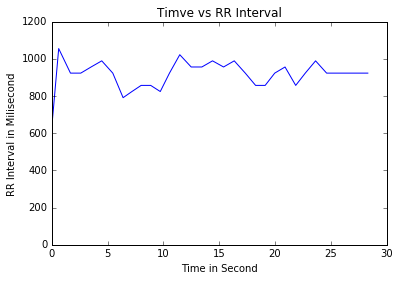

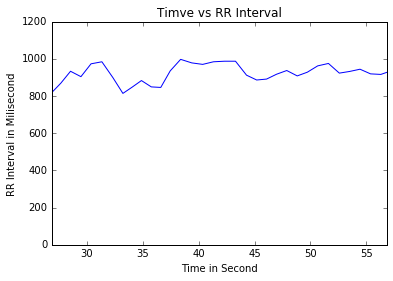

VID_20150123_172956_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  843.4060107566347


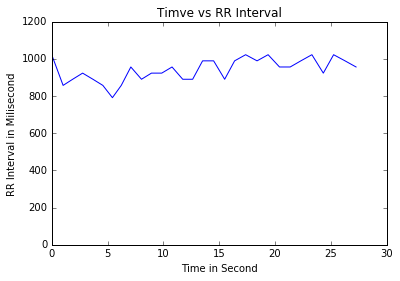

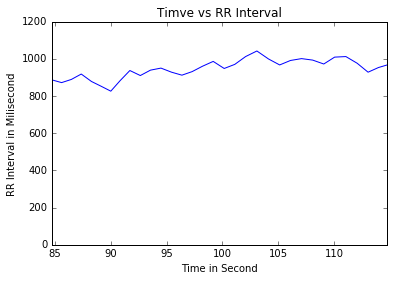

VID_20150123_173057_Q.mp4.txt
Percent Error for the RRITS in this video: 3.225806451612903
Alignment Distance:  1173.631978322339


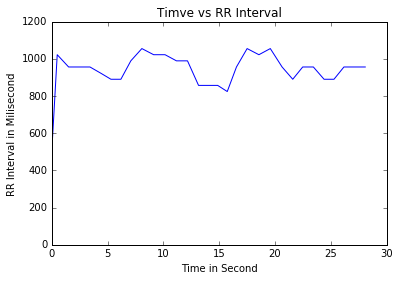

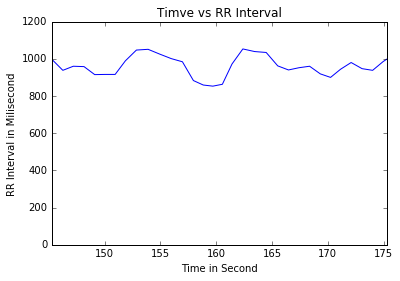

VID_20150123_173157_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  556.1584386526453


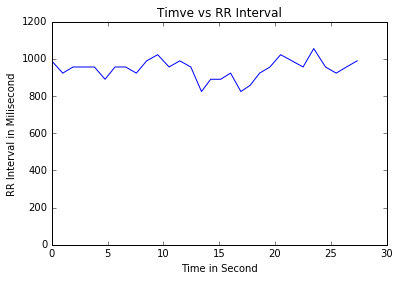

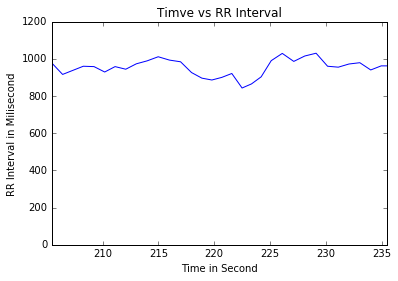

VID_20150123_173259_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  372.0277972281509


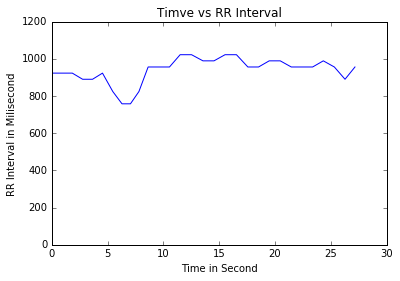

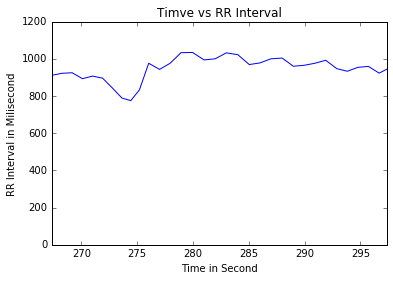

VID_20150123_173527_F.mp4.txt
Percent Error for the RRITS in this video: 33.333333333333336
Alignment Distance:  10283.252014782805


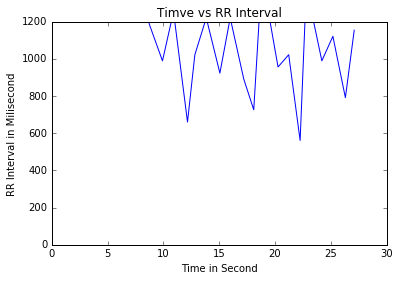

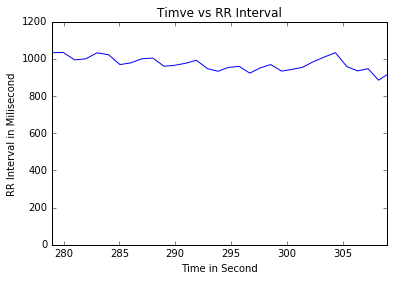

VID_20150123_173358_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  563.8135614303249


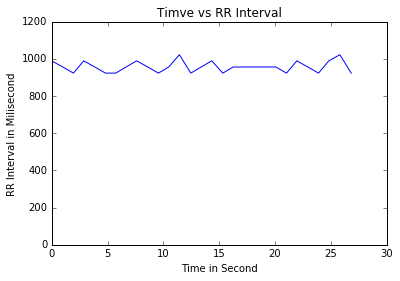

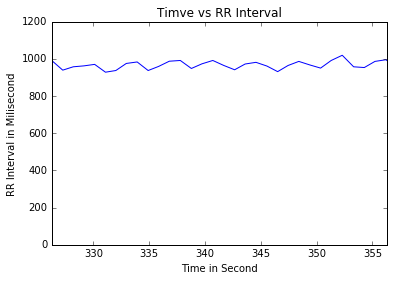

VID_20150123_173329_F.mp4.txt
Percent Error for the RRITS in this video: 53.57142857142857
Alignment Distance:  13860.570403447828


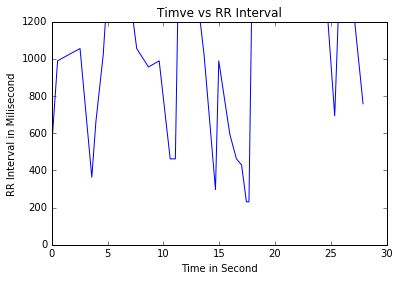

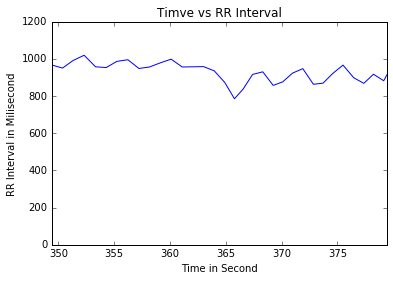

VID_20150123_173457_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  564.5634020773489


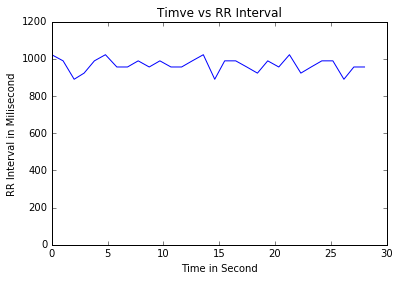

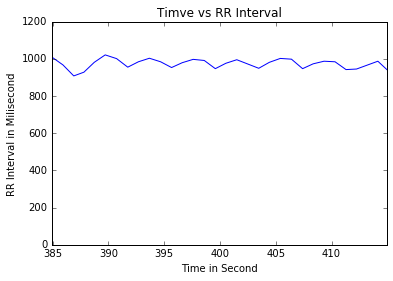

VID_20150123_173556_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  333.19363884106895


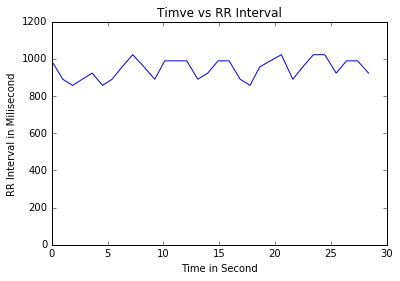

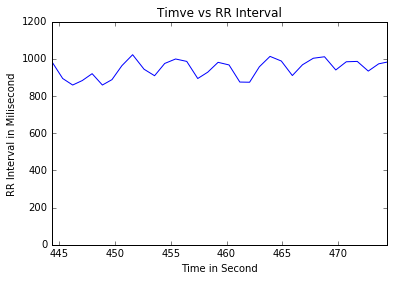

VID_20150123_173700_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  514.0767044829404


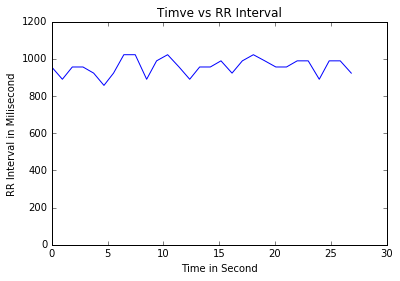

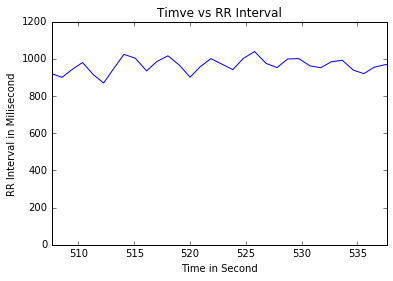

VID_20150123_173757_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  622.6045157875539


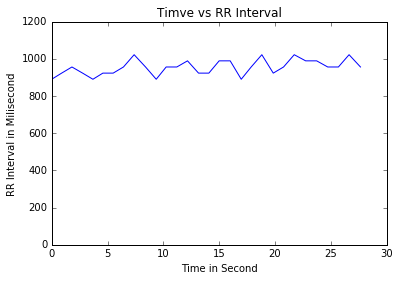

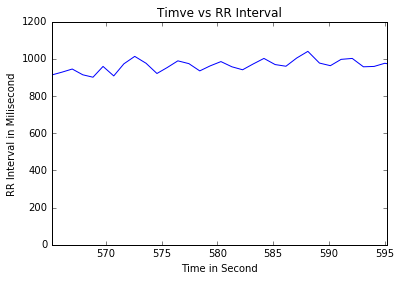

In [17]:
%matplotlib inline
ecg1TimeList = ecg1.getTimeList()
ecg1RRITList = ecg1.getRRITList()
ecg2TimeList = ecg2.getTimeList()
ecg2RRITList = ecg2.getRRITList()

#first for ecg1, which represents 15012301_GIO.hrm
for alignment in ecg1Result:
    time = alignment[0]
    distance = alignment[1]
    ppgRRITSignal = alignment[2]
    print(os.path.basename(ppgRRITSignal.name))
    print('Percent Error for the RRITS in this video:', ppgRRITSignal.percentError)
    print('Alignment Distance: ', distance)
    plt.plot(ppgRRITSignal.getTimeList(), ppgRRITSignal.getRRITList())
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(0,30)
    plt.ylim(0, 1200)
    plt.show()
    plt.plot(ecg1TimeList, ecg1RRITList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(time, time+30)
    plt.ylim(0, 1200)
    plt.show()

## 15012301_GLO.hrm

VID_20150123_172827_F.mp4.txt
Percent Error for the RRITS in this video: 2.3255813953488373
Alignment Distance:  1553.3987154150086


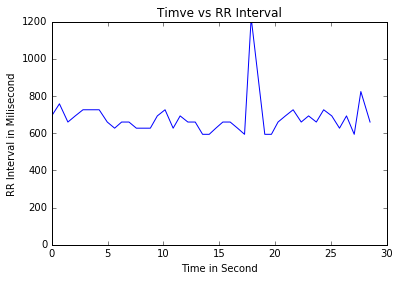

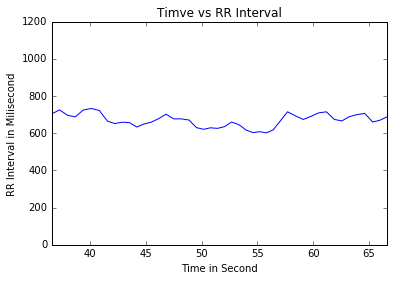

VID_20150123_172926_F.mp4.txt
Percent Error for the RRITS in this video: 2.5641025641025643
Alignment Distance:  1304.5355055541277


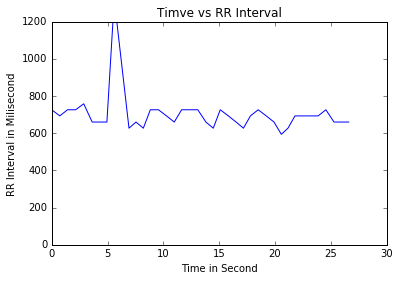

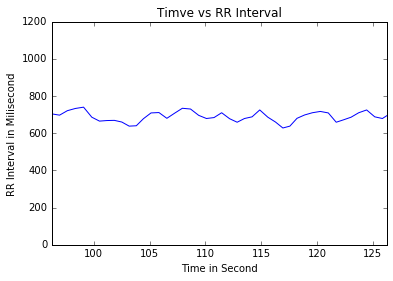

VID_20150123_173028_F.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  794.4187166365408


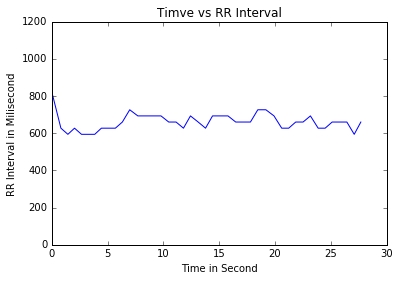

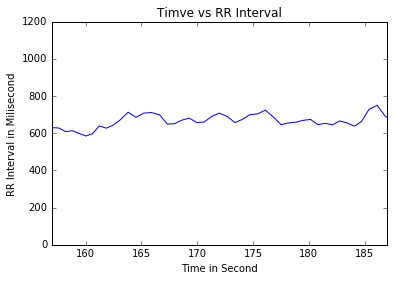

new_VID_20150123_173427_F.mp4.txt
Percent Error for the RRITS in this video: 59.375
Alignment Distance:  17718.95734043981


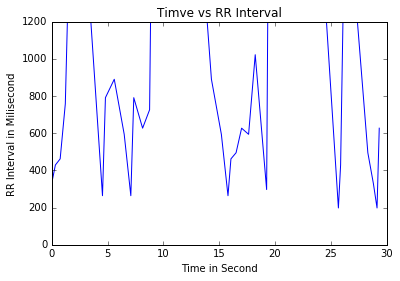

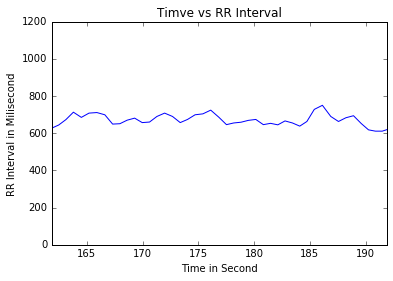

VID_20150123_173127_F.mp4.txt
Percent Error for the RRITS in this video: 2.3255813953488373
Alignment Distance:  1440.565370449147


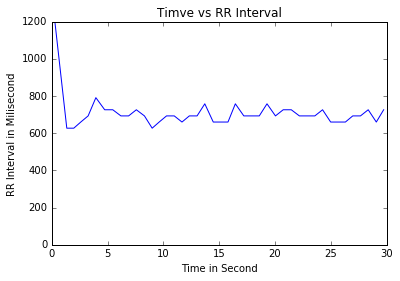

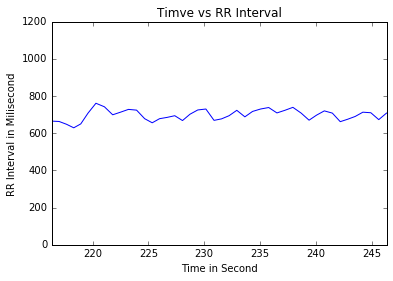

VID_20150123_173230_F.mp4.txt
Percent Error for the RRITS in this video: 4.761904761904762
Alignment Distance:  1237.2418962301397


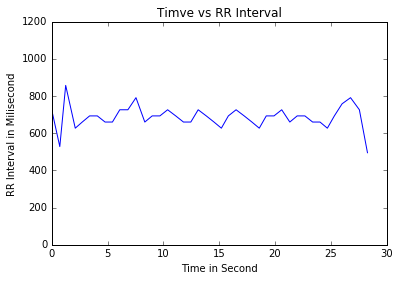

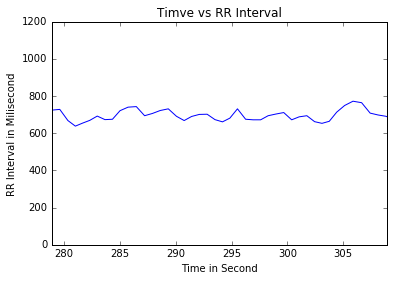

VID_20150123_173727_F.mp4.txt
Percent Error for the RRITS in this video: 14.285714285714286
Alignment Distance:  6158.145437806068


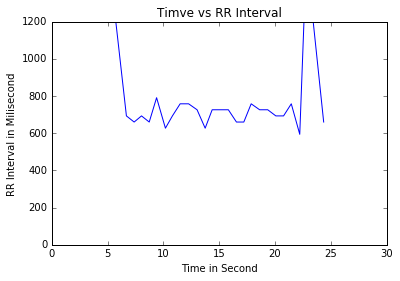

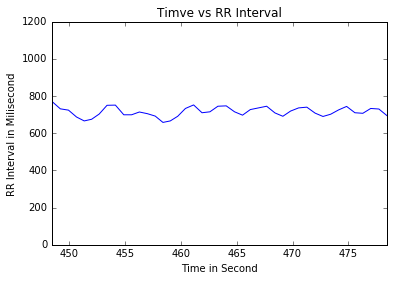

VID_20150123_173629_F.mp4.txt
Percent Error for the RRITS in this video: 21.21212121212121
Alignment Distance:  7407.786013130281


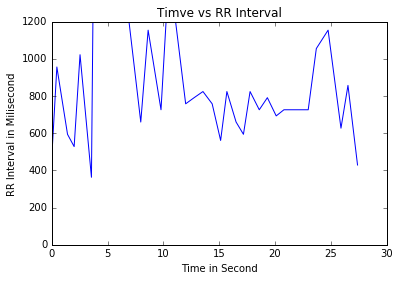

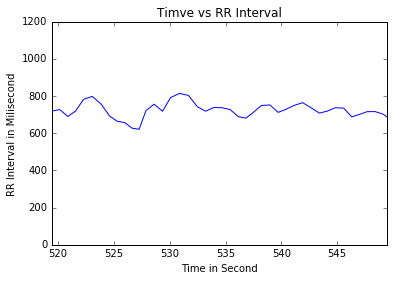

In [18]:
for alignment in ecg2Result:
    time = alignment[0]
    distance = alignment[1]
    ppgRRITSignal = alignment[2]
    print(os.path.basename(ppgRRITSignal.name))
    print('Percent Error for the RRITS in this video:', ppgRRITSignal.percentError)
    print('Alignment Distance: ', distance)
    plt.plot(ppgRRITSignal.getTimeList(), ppgRRITSignal.getRRITList())
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(0,30)
    plt.ylim(0, 1200)
    plt.show()
    plt.plot(ecg2TimeList, ecg2RRITList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(time, time+30)
    plt.ylim(0, 1200)
    plt.show()

# Conclusion:

Overall, we see a positive correlation between the PPG signal's RRIT identification percent error and its success in aligning to the ECG RRIT signal.